# Analysis of Separator Signal After the Capacitor was fitted


In [1]:
import altair as alt
import numpy as np
import pandas as pd

from src.data_processing import create_data_from_entry, unstable_seconds, calibrate_data, flatten_data, average_data

# Render altair charts correctly
alt.renderers.enable('notebook')

# Store the altair char json separately and not in the notebook 
# to reduce notebook size
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Analysis of 210 seconds

### Raw data Analysis

First we load and clean the data and calibrated the data to the separator PSU voltage.

In [2]:
def clean_camonitored_data(data):
    """
    Cleans file produced from camonitoring a PV.

    Args:
        data (pandas Dataframe): Pandas Dataframe to be parsed.
    Returns:
        cleaned_dataframe (Dataframe): Cleaned dataframe
    """
    columns = ["PV name", "Date", "Time", "NELM"]
    columns.extend(list(range(1, 100 + 1)))
    data.columns = columns

    data["Datetime"] = pd.to_datetime(data["Date"] + ' ' + data["Time"])

    new_columns = ["Datetime"]
    new_columns.extend(list(range(1, 100 + 1)))
    cleaned_dataframe = data[new_columns]


data = pd.read_csv("C:\\Users\\olz75487\\Documents\\muonfe\\data\\raw\\2018-11-09-voltage-data-cleaned.csv", 
                   nrows=210)
calibrated_data = calibrate_data(data, 20)
calibrated_data = calibrated_data.sort_index(axis=1)

In [3]:
calibrated_data = calibrate_data(data, 20)

Now we flatten each array of data by asigning a time stamp to each element of the array in the following way:

- Given a row,  finding the time delta between this row and the next row,
- Dividing this time delta by the number of elements in an array (100 in this case) to get the time delta between readings.
- For each element of the array, multiple the time delta between readings and the position of the element in the array and add this to the time reading for the row.

Note this assumes that readings are sampled equally spaced apart.

In [4]:
flatten_raw_data = flatten_data(calibrated_data)
flatten_raw_data.head()

,Datetime,Value
0,2018-11-09 10:46:08.559401000,92.6090
1,2018-11-09 10:46:08.571347010,93.7440
2,2018-11-09 10:46:08.583293020,92.6600
3,2018-11-09 10:46:08.595239030,93.6674
4,2018-11-09 10:46:08.607185040,92.6792


In [5]:
# These charts create rules to show the mean and stability limits.
raw_limits = pd.DataFrame([{
    'average': np.mean(flatten_raw_data.loc[:, "Value"]),
    'low_limit': np.mean(flatten_raw_data.loc[:, "Value"]) - 1,
    'high_limit': np.mean(flatten_raw_data.loc[:, "Value"]) + 1
}])

mean = alt.Chart(raw_limits).mark_rule(color='#09881F', opacity=0.5).encode(
    y = "average:Q",
    size=alt.value(3)
)

low_limit = alt.Chart(raw_limits).mark_rule(color='#CE270B', opacity=0.5).encode(
    y = "low_limit:Q",
    size=alt.value(3)
)

high_limit = alt.Chart(raw_limits).mark_rule(color='#CE270B', opacity=0.5).encode(
    y = "high_limit:Q",
    size=alt.value(3)
)

limits_layer = alt.layer( mean, high_limit, low_limit, data=raw_limits)

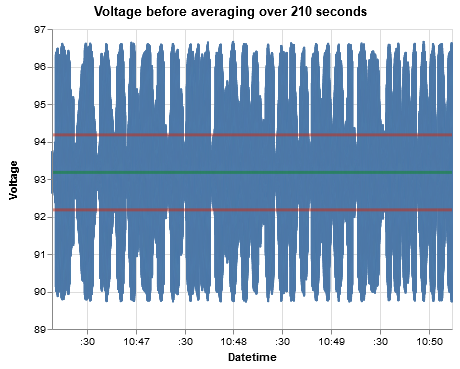

In [17]:
# Graph the line
base_line = alt.Chart().mark_line().encode(
    alt.X("Datetime:T", title="Datetime"),
    alt.Y("Value:Q", scale = alt.Scale(domain=[89, 97]), title="Voltage")
)

alt.layer(base_line, limits_layer, data=flatten_raw_data, title="Voltage before averaging over 210 seconds", config={"background": "white"})

In [7]:
raw_mean = np.mean(flatten_raw_data)
raw_mean

Value    93.176535
dtype: float64

In [8]:
raw_std = np.std(flatten_raw_data)
raw_std

Value    2.394099
dtype: float64

The graph above shows how often the signal is outside of the stability parameters set at $\pm1kV$ from the mean. We also see that the signal has a standard deviation of $2.394288kV$ from a mean of $93.176931kV$.

In [9]:
raw_unstable_seconds = unstable_seconds(flatten_raw_data, float(raw_mean))
raw_unstable_seconds

160.19

The number of unstable seconds is 161.87 over this 210 second window.

### Averaging the data

Now we will average the data by averaging values which are 180 degrees apart on the 50Hz wave. As this data was collected while sampling 100 elements at 100Hz (new reading every second) we need to average each pair of elements. We set the timestamp of the average to the later element's timestamp.

In [10]:
averaged_data = average_data(flatten_raw_data)

In [11]:
averaged_data_mean = np.mean(averaged_data)
averaged_data_mean

Value    93.176466
dtype: float64

In [12]:
np.std(averaged_data)

Value    0.186195
dtype: float64

In [13]:
1- np.std(averaged_data)/np.std(flatten_raw_data)

Value    0.922228
dtype: float64

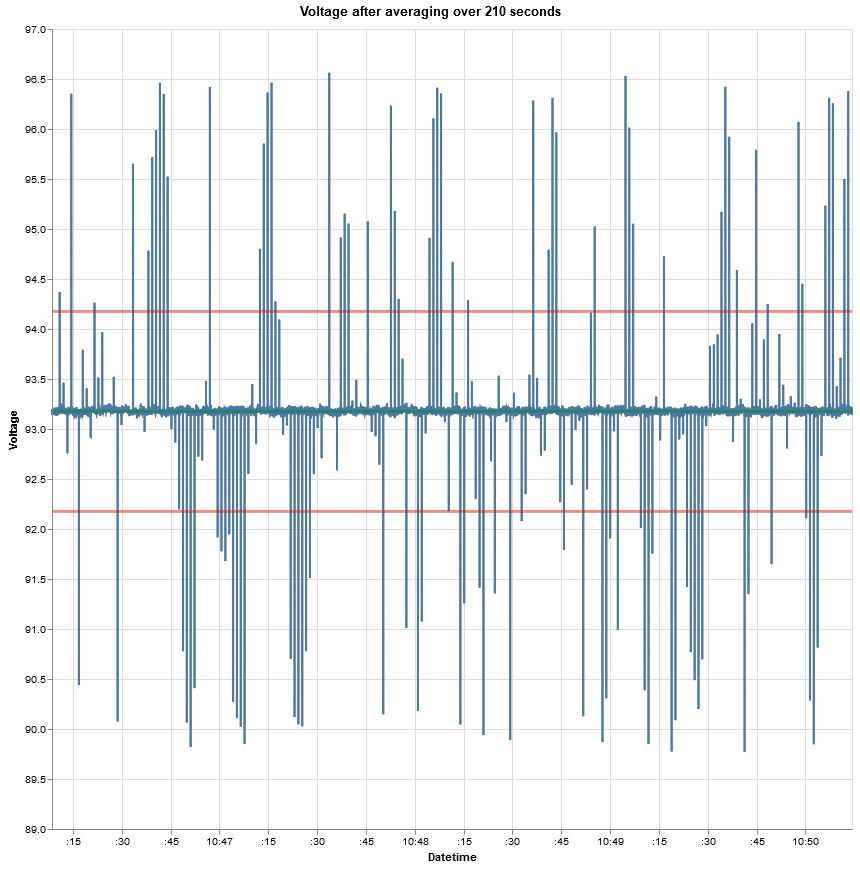

In [14]:
averaged_limits = pd.DataFrame([{
    'average': np.mean(averaged_data.loc[:, "Value"]),
    'low_limit': np.mean(averaged_data.loc[:, "Value"]) - 1,
    'high_limit': np.mean(averaged_data.loc[:, "Value"]) + 1
}])
averaged_limits_layer = alt.layer( mean, high_limit, low_limit, data=averaged_limits)

alt.layer(base_line,averaged_limits_layer, data=averaged_data, title="Voltage after averaging over 210 seconds", config={"background": "white"})

The graph above shows how often the signal is outside of the stability parameters set at $\pm1kV$ from the mean. We also see that the signal has a standard deviation of $0.152311kV$ from a mean of $93.177028kV$. This is a $93.6386\%$ reduction of the standard deviation.

In [15]:
averaged_unstable_second = unstable_seconds(averaged_data, float(averaged_data_mean))
averaged_unstable_second

1.08

In [16]:
1 - averaged_unstable_second/raw_unstable_seconds

0.9932580061177352

The number of unstable seconds is 0.74 seconds over this 210 second window- a 99.54% decrease in the amount of time spent unstable.